In [411]:
import torch
import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt

from coshrem.shearletsystem import EdgeSystem
from coshrem.util.image import overlay, mask, thin_mask, curvature_rgb
from coshrem.util.curvature import curvature
import coshrem.util
from PIL import Image

fftlib = np.fft

In [426]:


def sheardec2D(X, shearlets):
    #skipping useGPU stuff...
    coeffs = np.zeros(shearlets.shape, dtype=complex)

    # get data in frequency domain
    Xfreq = fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(X)))

    # compute shearlet coefficients at each scale
    # note that pointwise multiplication in the fourier domain equals
    # convolution in the time-domain
    for j in range(shearlets.shape[-1]):
        coeffs[:,:,j] = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift(Xfreq*np.conj(shearlets[:,:,j]))))

    return coeffs


def shearrec2D(coeffs, shearlets, dualFrameWeights):
    # skipping useGPU stuff...
    X = np.zeros((coeffs.shape[0], coeffs.shape[1]), dtype=complex)

    for j in range(shearlets.shape[-1]):
        X = X + fftlib.fftshift(fftlib.fft2(fftlib.ifftshift(coeffs[:,:,j])))*shearlets[:,:,j]

    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights==np.inf] = 0.0

    X = fftlib.fftshift(fftlib.ifft2(fftlib.ifftshift((X*InversedualFrameWeights))))

    return np.real(X)

In [427]:
import os, time
import numpy as np
from PIL import Image
from coshrem.shearlet import construct_shearlet
from numpy.random import randint
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.transform import resize

#import numba

from coshrem.util.cone import cone_orientation
from coshrem.shearlet import yapuls, padarray, shear, construct_shearlet
from matplotlib.colors import hsv_to_rgb

import torch

from shnetutil import cplx, shxform
from shnetutil.shxform import CoShREMConfig
import cplxmodule
from shnetutil.utils import torchutils
from shnetutil.cplx import visual

# Default parameters for our Shearlet system
# https://www.math.colostate.edu/~king/software/CoShREM_Parameter_Guide.pdf
#

ksh_spec = CoShREMConfig(
			rows = 32,
			cols = 32,
			scales_per_octave = 2,
			shear_level = 3,
			octaves = 1,
			alpha = .5,	#   Anisotropy level
						#	alpha: coefficient determining level of anisotropy. 
						#	1 -> wavelets, 
						#	0.5 -> shearlets, 
						#	0 -> ridgelets... etc.

			wavelet_eff_support = 7,
			gaussian_eff_support = 14,
)

def get_sh_spec(rows:int, cols:int, alpha:float=0.5):
	""" Configure a sh_spec for our Shearlet system """
	sh_spec = ksh_spec.copy()
	sh_spec['rows'] = rows
	sh_spec['cols'] = cols
	sh_spec['alpha'] = alpha
	return sh_spec

def get_CoShXform(device:str, rows:int, cols:int, alpha:float=0.5):
	""" Start a CoShXform """
	sh_spec = get_sh_spec(rows, cols, alpha)
	coshxform = CoShXform(sh_spec)
	coshxform.start(device)
	return coshxform	

def power_of_two(target):
	""" round to next power-of-2 """
	if target > 1:
		for i in range(1, int(target)):
			if (2 ** i >= target):
				return 2 ** i
	else:
		return 1

class CoShXform(shxform.ShXform):
	def __init__(self,
		sh_spec = ksh_spec, 
		tocplx = False,
		topolar = False,
		phase_first = False
	):
		""" Generating the shearlet system with pyCoShRem """
		super().__init__(sh_spec=sh_spec)	#default complex Shearlet spec - usually provided by client
		nextp2 = power_of_two(self.dim[0])
		assert(nextp2 == self.dim[0])
		self.ourdim = (nextp2, nextp2)
		self.tocplx = tocplx
		self.topolar = topolar
		self.phase_first = phase_first
		#print(f"CoShXform: {sh_spec}")

	def __repr__(self):	
		return f"CoShXform({self.sh_spec})"	

	def __str__(self):
		return f"CoShXform({self.sh_spec})"	

	def start(self, device):
		super().start(device)

		#t = time.time()
		self._shearletSystem = getcomplexshearlets2D(**dict(self.sh_spec))
		#self.shearlets, self.shearletIdxs = self.shearletSystem
		#print(f"Elapsed time: getcomplexshearlets2D() {time.time()-t:3f}ms")

		#for pytorch deal with the imaginary and real part we separate them into two arrays
		shearlets_complex = to_torch_complex(self.shearlets)
		self.shearlets_complex = shearlets_complex
		self.torch_shearlets = torch.tensor(shearlets_complex).unsqueeze(0).to(device).float()
	
def to_torch_complex(shearlets):
	"""for pytorch to deal with the imaginary and real part we separate them into two arrays """
	#print(f"to_torch_complex {shearlets.shape}")
	shearlets_complex = np.concatenate((
		shearlets.real[:,:,:,np.newaxis], 
		shearlets.imag[:,:,:,np.newaxis]), 
		3
	)
	return shearlets_complex

# ## Relevant CoShReM function

# Single shearlet computation
def _single_shearlet(
	rows, cols, 
	wavelet_eff_supp,
	gaussian_eff_supp, scales_per_octave,
	shear_level, alpha, 
	sample_wavelet_off_origin,
	scale, ori, _coneh, _ks, hilbert_matrix
):
	shearlet_f = construct_shearlet(rows, cols, wavelet_eff_supp,
								  gaussian_eff_supp, scales_per_octave,
								  shear_level, alpha,
								  sample_wavelet_off_origin, scale, ori, _coneh, _ks)

	if ori in _coneh:
		shearlet_f = shearlet_f + (hilbert_matrix[:, :, 0] * shearlet_f)
		# shearlet_f = np.fliplr(np.flipud(_hilbert_f(shearlet_f * -1)))
		# if not self.sampleWaveletOffOrigin:
		#     shearlet_f = np.roll(shearlet_f, -1, axis=0)
	else:
		if ori > np.max(_coneh):
			shearlet_f = -1 * (shearlet_f + hilbert_matrix[:, :, 1] * shearlet_f)
			# shearlet_f = _hilbert_f(shearlet_f.T * -1).T
			# shearlet_f = np.roll(shearlet_f, 1, axis=1)
		else:
			shearlet_f = shearlet_f + hilbert_matrix[:, :, 1] * shearlet_f
			# shearlet_f = _hilbert_f(shearlet_f.T).T
	return shearlet_f

def getcomplexshearlets2D(
	rows, 
	cols, 
	scales_per_octave, 
	shear_level, 
	octaves, alpha,
	wavelet_eff_support = 7,
	gaussian_eff_support = None,
):

	# Parameters precomputing
	gaussian_eff_support = gaussian_eff_support if gaussian_eff_support else wavelet_eff_support * 2 
	wavelet_eff_supp = np.min((rows, cols)) / wavelet_eff_support
	gaussian_eff_supp = np.min((rows, cols)) / gaussian_eff_support
	sampleWaveletOffOrigin= True

	hilbert_matrix = np.ones((rows, cols, 2))
	hilbert_matrix[:(rows//2), :, 0] = -1
	hilbert_matrix[:, (cols//2):, 1] = -1
	n_oris = 2 ** shear_level + 2
	scales = np.arange(1, (scales_per_octave * octaves) + 1)
	n_shearlets = len(scales) * n_oris

	normalize=True
	_, _coneh, _ks =  cone_orientation(shear_level)
	shearlets = np.zeros((rows, cols,n_shearlets), dtype=np.complex_)
	shearletidx = []
	# Computing shearlets
	for j, scale in enumerate(scales):
		for ori in range(n_oris):
			shearlet = _single_shearlet(rows, cols, wavelet_eff_supp,
						   gaussian_eff_supp, scales_per_octave,
						   shear_level, alpha, sampleWaveletOffOrigin,
						   scale, ori+1, _coneh, _ks, hilbert_matrix)

			if ori in _coneh:
				shearletidx.append([1,int(scale), _ks[ori]])
			else:
				shearletidx.append([2,int(scale), _ks[ori]])
			shearlets[:, :, n_oris * j + ori] = shearlet
	# Computing RMS (Root mean square)
	RMS = np.linalg.norm(shearlets[0], axis=(0, 1))/np.sqrt(rows*cols)
	dualFrameWeights = np.sum(np.power(np.abs(shearlets), 2), axis=2)
	return shearlets, shearletidx, RMS, dualFrameWeights



<class 'numpy.ndarray'> 0 254


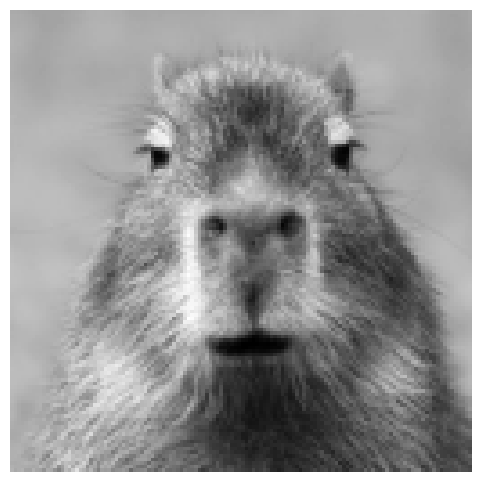

sh_spec: rows=128 cols=128 scales_per_octave=1 shear_level=3 octaves=1 alpha=0.5 wavelet_eff_support=256 gaussian_eff_support=128
torchutils.onceInit device = cuda:0
initSeeds(1)
0.013697453999305156


/tmp/ipykernel_2060515/2036477480.py:24: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


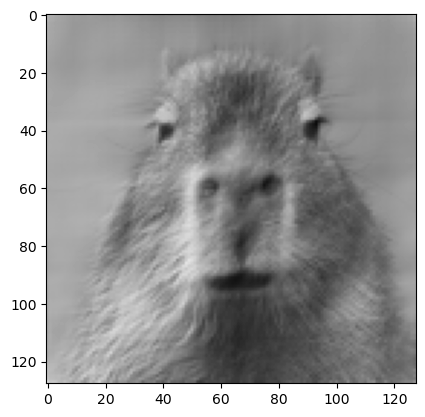

In [428]:
size = 128
img = np.array(Image.open("capybara.png").convert('L'))
print(type(img), img.min(), img.max())
image = resize(img, (size,size))

plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(image, cmap = "gray")
plt.show()

# Relevant parameters for our Shearlet system
rows, cols = image.shape
sh_spec = CoShREMConfig(rows = rows,
                        cols = cols,
                        scales_per_octave = 1,
                        shear_level = 3,
                        octaves = 1,
                        alpha = 0.5,
                        wavelet_eff_support = 256,
                        gaussian_eff_support = 128)

print(f"sh_spec: {sh_spec}")

# Generating the shearlet system with pyCoShRem
device = torchutils.onceInit(kCUDA=True)
coshxform = CoShXform(sh_spec)
coshxform.start(device)

shearlets, shearletIdxs, RMS, dualFrameWeights = coshxform.shearletSystem

print(RMS)

coeffs = sheardec2D(image, shearlets)
recon = shearrec2D(coeffs, shearlets, dualFrameWeights)

# visual.complexImageShow(recon)
plt.imshow(recon.real, cmap='gray', vmin=0, vmax=1)
plt.show()

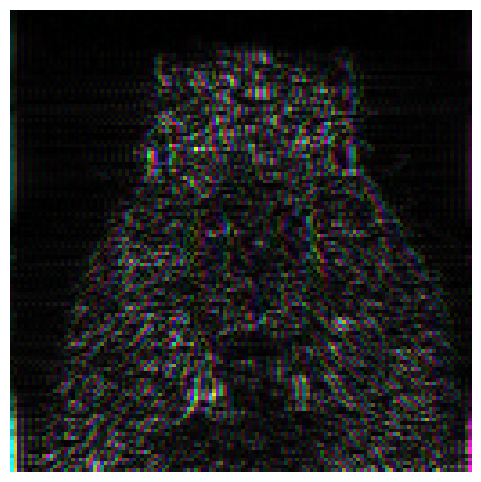

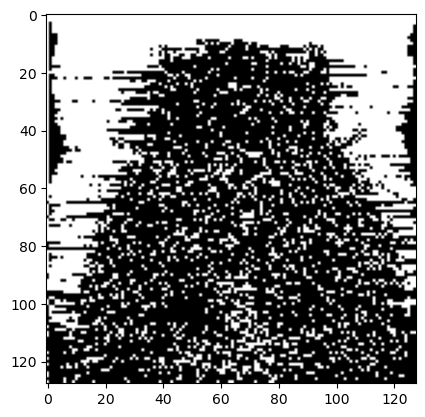

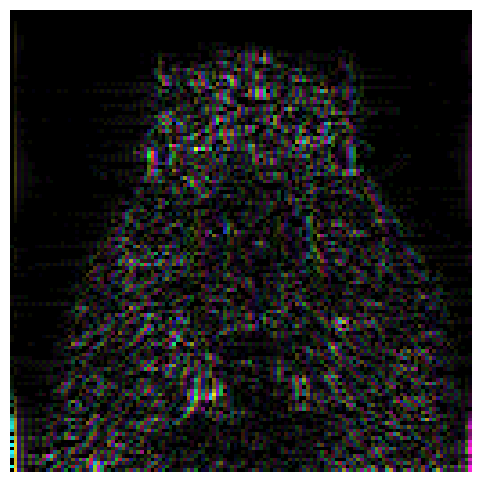

real zeros: tensor(6554)
tensor(0.4000)


/tmp/ipykernel_2060515/2036477480.py:24: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


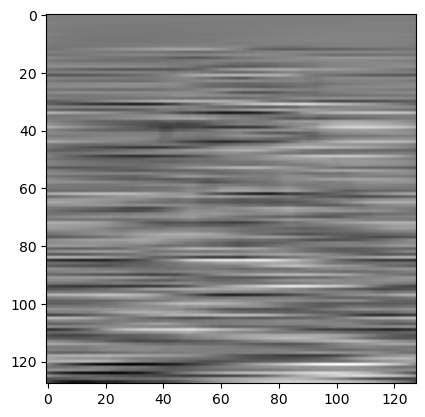

In [429]:
from copy import deepcopy as copy
def is_peak(coeffs):
    coeffs = np.array(coeffs)
    up = np.roll(coeffs, 1, -2)
    down = np.roll(coeffs, -1, -2)
    right = np.roll(coeffs, 1, -3) < coeffs
    left = np.roll(coeffs, -1, -3) < coeffs

    up_right = np.roll(coeffs, 1, -3) < coeffs
    up_left = np.roll(coeffs, -1, -3) < coeffs
    down_right = np.roll(down, 1, -3) < coeffs
    down_left = np.roll(down, -1, -3) < coeffs

    up = up < coeffs
    down = down < coeffs

    mask = up * down * right * left * up_right * up_left * down_right * down_left
    return mask

def suppress_peaks(coeffs):
    peaks = is_peak(coeffs)
    coeffs[peaks] = 0
    return coeffs

def suppress_non_peak(coeffs):
    peaks = is_peak(coeffs)
    coeffs[~peaks] = 0
    return coeffs
    
def suppress_small(coeffs, percent=10):
    importance = np.abs(coeffs.real)

    qLower = np.percentile(importance, percent) # 10% sparsity
    mask = importance < qLower

    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    plt.show()

    coeffs[mask] = 0

    return coeffs 

def suppress_large(coeffs, percent=10):
    importance = np.absolute(coeffs.real)

    qLower = np.percentile(importance, 100 - percent) # 10% sparsity
    mask = importance > qLower
    coeffs[mask] = 0

    return coeffs 

def suppress_random(coeffs, percent=10):
    mask = np.random.rand(*coeffs.shape) < (percent / 100)
    coeffs[mask] = 0

    return coeffs 


def peaks_compression(normalized_img):
    recon = []
    coeffs_arr = []
    bands = 1 # 99% sparsity
    coeffs = sheardec2D(normalized_img, shearlets)

    coeffs = torch.tensor(coeffs[..., :bands])
    dualFrameWeights = torch.tensor(np.sum(np.power(np.abs(shearlets[..., :bands]), 2), axis=2))

    maxval = coeffs.real.max()

    visual.complexImageShow(coeffs / maxval)
    plt.show()

    coeffs = suppress_small(coeffs, 40)

    visual.complexImageShow(coeffs / maxval)
    plt.show()

    print('real zeros:', (coeffs.real == 0).sum())

    coeffs_arr.append(copy(coeffs))

    recon.append(shearrec2D(np.array(coeffs), np.array(shearlets[..., :bands]), dualFrameWeights.numpy()))

    sparsity = (torch.tensor(np.stack(coeffs_arr, 0)) == 0).sum() / torch.tensor(np.stack(coeffs_arr, 0)).flatten().shape[0]

    print(sparsity)

    return torch.tensor(np.stack(recon, 0)).real

ima = peaks_compression(image)
ima -= ima.min()
ima /= ima.max()

plt.imshow(ima[0], cmap='gray', vmin=0, vmax=1) # worth noting that this is still larger than the original image even considering sparsity
plt.show()

In [430]:
def get_importance(coeffs, shearlets):
    InversedualFrameWeights = 1 / dualFrameWeights
    InversedualFrameWeights[InversedualFrameWeights == np.inf] = 0.0

    importances = []
    for i in range(coeffs.shape[2]):
        Xfreq = fftshift(fft2(ifftshift(coeffs[:, :, i]))) * np.conj(
                    shearlets[:, :, i]
                )
        importances.append(InversedualFrameWeights * Xfreq)

    importance = np.stack(importances, -1)
    
    return np.absolute(coeffs.real)

In [431]:
ksh_spec = CoShREMConfig(
			rows = 32,
			cols = 32,
			scales_per_octave = 2,
			shear_level = 3,
			octaves = 1,
			alpha = .5,	#   Anisotropy level
						#	alpha: coefficient determining level of anisotropy. 
						#	1 -> wavelets, 
						#	0.5 -> shearlets, 
						#	0 -> ridgelets... etc.

			wavelet_eff_support = 7,
			gaussian_eff_support = 14,
)

device = torchutils.onceInit(kCUDA=True)
coshxform = CoShXform(sh_spec)
coshxform.start(device)

shearlets, shearletIdxs, RMS, dualFrameWeights = coshxform.shearletSystem

torchutils.onceInit device = cuda:0
initSeeds(1)


In [654]:
import math


def npimg2torch(img):
    if isinstance(img, torch.Tensor):
        return img

    img = torch.tensor(img)
    length = len(img.shape)
    assert length >= 2
    while len(img.shape) < 4:
        print(len(img.shape))
        img = img.unsqueeze(0)
    
    if length == 3:
        img = img.permute(0, 3, 1, 2)

    return img


def torchimg2np(img):
    if isinstance(img, np.ndarray):
        return img
    img = img.permute(0, 2, 3, 1)
    img = img.squeeze()
    return img.cpu().numpy()


class ShearletPyramid:
    def __init__(self, res_height, res_width, upsample_mode='custom'):
        assert upsample_mode in ['torch', 'custom'], 'upsample mode must be one of: torch, custom'
        self.upsample = supports_complex_torchupsample if upsample_mode == 'torch' else upsample_to_resolution
        # eventually we want to support any resolution
        # for now support square powers of two
        # in the future we can resize the dimensions to be to the closest power of two
        # we are forced into power of two by the torch ffts
        # we can set the supports to the minimum size
        self.resolution = (res_height, res_width)
        self.max_octaves = int(math.log2(res_height))
        self.min_scale = 5
        print('max octaves', self.max_octaves, 2**self.max_octaves)
        # generate a pyramid of systems
        self.pyramid = dict()
        self.device = torchutils.onceInit(kCUDA=True)
        for octave in range(self.min_scale, self.max_octaves + 1):
            spec = CoShREMConfig(
                rows = 2**octave,
                cols = 2**octave,
                scales_per_octave = 1,
                shear_level = 3,
                octaves = 1,
                alpha = .5,
                wavelet_eff_support = 2**octave,
                gaussian_eff_support = 2**(octave - 1),
            )
            sh_system = CoShXform(spec)
            sh_system.start(self.device)
            shearlets, shearletIdxs, RMS, dualFrameWeights = sh_system.shearletSystem
            self.pyramid[octave] = {'shearlets': shearlets,  'shearletIdxs': shearletIdxs, 'RMS': RMS, 'dualFrameWeights': dualFrameWeights}


    def compute_residual(self, image, coefficients):
        octaves = sorted(list(coefficients.keys()))

        residual = image.astype(np.float64)
        reconstruction = np.zeros_like(image).astype(np.float64)

        if len(octaves):
            assert octaves[-1] < self.max_octaves

        # we CAN do this all with one single transformation if we create the right shearlet system
        for octave in octaves:
            # upsample the coefficients to the current resolution
            upsampled_coeffs = torchimg2np(self.upsample(coefficients[octave], (2**(octaves[-1] + 1), 2**(octaves[-1] + 1)), mode='bilinear'))
            # retrieve the shearlets and the frame weights from the next level of the pyramid
            dualFrameWeights = self.pyramid[octaves[-1] + 1]['dualFrameWeights']
            shearlets = self.pyramid[octaves[-1] + 1]['shearlets']
            # subtract the upsampled reconstruction to create a residual
            recon = shearrec2D(np.array(upsampled_coeffs), np.array(shearlets), dualFrameWeights).astype(np.float64)
            residual -= recon
            reconstruction += shearrec2D(np.array(upsampled_coeffs), np.array(shearlets), dualFrameWeights)

        if len(octaves):
            # plt.imshow(residual, cmap='gray')
            # plt.show()
            pass

        return residual
    

    def compute_reconstruction(self, image, coefficients):
        # we technically only need the image size (TODO)
        image = npimg2torch(image)
        image = torch.nn.functional.interpolate(image, self.resolution, mode='bilinear')
        reconstruction = np.zeros_like(torchimg2np(image)).astype(np.float64)

        octaves = sorted(list(coefficients.keys()))
        print('max size', 2**octaves[-1])

        # we CAN do this all with one single transformation if we create the right shearlet system (TODO)
        for octave in octaves:
            # upsample the coefficients to the current resolution
            upsampled_coeffs = torchimg2np(self.upsample(coefficients[octave], (2**(octaves[-1]), 2**(octaves[-1])), mode='bilinear'))
            dualFrameWeights = self.pyramid[octaves[-1]]['dualFrameWeights']
            shearlets = self.pyramid[octaves[-1]]['shearlets']
            # subtract the upsampled reconstruction to create a residual
            print(octave, np.array(upsampled_coeffs).shape, np.array(shearlets).shape, dualFrameWeights.shape)
            reconstruction += shearrec2D(np.array(upsampled_coeffs), np.array(shearlets), dualFrameWeights)

        return reconstruction
    

    def suppress_small(self, coeffs, percent=0.1):
        importance = torch.abs(torch.cat([(2**(self.max_octaves - k)) + torch.tensor(value).flatten() for k, value in coeffs.items()]).real)
        threshold = torch.quantile(importance, percent, interpolation='higher')

        for k, coeff in coeffs.items():
            mask = torch.abs(coeff.real) < threshold
            coeffs[k][mask] = 0.0

        return coeffs 
    

    def expensive_compress(self, img, components=512):
        spec = CoShREMConfig(
            rows = 2**self.max_octaves,
            cols = 2**self.max_octaves,
            scales_per_octave = 2,
            shear_level = 3,
            octaves = (self.max_octaves - self.min_scale) + 1,
            alpha = .5,
            wavelet_eff_support = 2**self.max_octaves,
            gaussian_eff_support = 2**(self.max_octaves - 1),
        )
        sh_system = CoShXform(spec)
        sh_system.start(self.device)
        shearlets, shearletIdxs, RMS, dualFrameWeights = sh_system.shearletSystem

        img = npimg2torch(img)
        img = torch.nn.functional.interpolate(img, self.resolution, mode='bilinear')

        fitted_coefficients = npimg2torch(sheardec2D(img, shearlets))

        channels_per_octave = (2 ** 4) + 2
        print('number of scales', fitted_coefficients.shape[1] / channels_per_octave)
        print('self.max_octaves - self.min_scale =', self.max_octaves - self.min_scale)
        print('coeffs shape', fitted_coefficients.shape)

        coefficients = dict()
        for octave in range((self.max_octaves - self.min_scale) + 1):
            coefficients[self.max_octaves - octave] = supports_complex_torchupsample(fitted_coefficients[:, octave*channels_per_octave:(octave+1)*channels_per_octave], (2**(self.min_scale + octave), 2**(self.min_scale + octave)))
        print(img.shape)
        reconstruction = self.compute_reconstruction(img, coefficients)
        plt.imshow(reconstruction, cmap='gray')
        plt.show()
        # plt.imshow(torchimg2np(torch.nn.functional.interpolate(img, (2**octave, 2**octave))), cmap='gray')
        # plt.show()
        return coefficients

    def compress(self, img, components=512):
        # TODO: support RGB images
        # store a copy of the original image
        img = npimg2torch(img)
        img = torch.nn.functional.interpolate(img, self.resolution, mode='bilinear')

        coefficients = dict()
        for octave in range(self.min_scale, self.max_octaves + 1):
            # resize the image
            image_octave = torchimg2np(torch.nn.functional.interpolate(img, (2**octave, 2**octave)))
            shearlets, _ = self.pyramid[octave]['shearlets'], self.pyramid[octave]['dualFrameWeights']
            # decode the coefficients for the image
            coefficients[octave] = npimg2torch(sheardec2D(self.compute_residual(image_octave, coefficients), shearlets))

        # coefficients = self.suppress_small(coefficients)

        reconstruction = self.compute_reconstruction(img, coefficients)
        plt.imshow(reconstruction, cmap='gray')
        plt.show()
        # plt.imshow(torchimg2np(torch.nn.functional.interpolate(img, (2**octave, 2**octave))), cmap='gray')
        # plt.show()
        return coefficients
    

def upsample_with_zeros(tensor_img, blur=False):

    if len(tensor_img.shape) < 4: # then this is a np image and must be converted
        tensor_img = npimg2torch(tensor_img)

    blur_mag = torchvision.transforms.GaussianBlur(5, sigma=16)
    blur_phase = torchvision.transforms.GaussianBlur(5, sigma=128)

    # need spatial dimensions first for the interleaving operation
    tensor_img = tensor_img.permute(2, 3, 0, 1)
    # print(tensor_img.shape)
    log_size = int(math.log2(tensor_img.shape[0]))
    tup = (tensor_img, torch.zeros_like(tensor_img)) if log_size % 2 else (torch.zeros_like(tensor_img), tensor_img)
    interleaved_img = torch.stack(tup, dim=2).view(tensor_img.shape[0], -1, tensor_img.shape[-2], tensor_img.shape[-1])

    tensor_img = interleaved_img.permute(1, 0, 2, 3)

    tup = (tensor_img, torch.zeros_like(tensor_img)) if log_size % 2 else (torch.zeros_like(tensor_img), tensor_img)
    interleaved_img = torch.stack(tup, dim=2).view(tensor_img.shape[0], -1, tensor_img.shape[-2], tensor_img.shape[-1])
    interleaved_img = interleaved_img.permute(2, 3, 1, 0)

    if blur:
        if interleaved_img.dtype in [torch.complex64, torch.complex32, torch.complex128]:
            interleaved_img.real = blur_mag(interleaved_img.real)
            interleaved_img.imag = blur_phase(interleaved_img.real)

    return interleaved_img

def upsample_to_resolution(tensor_img, resolution=None, scale_factor=None, bilinear=False, **kwargs):
    if len(tensor_img.shape) < 4: # then this is a np image and must be converted
        tensor_img = npimg2torch(tensor_img)

    assert resolution[0] == resolution[1], 'only currently supporting square power of two resolution images'
    assert tensor_img.shape[-1] == tensor_img.shape[-2], 'only currently supporting square power of two resolution images'
    
    resolution = resolution[0]
    assert math.log2(resolution) == int(math.log2(resolution)), 'only currently supporting square power of two resolution images'
    
    upsamples = int(math.log2(resolution / tensor_img.shape[-1])) if resolution is not None else scale_factor

    for i in range(upsamples):
        if i < (upsamples - 1):
            tensor_img = upsample_with_zeros(tensor_img)
        else:
            if bilinear:
                tensor_img_up = torch.zeros((tensor_img.shape[0], tensor_img.shape[1], 2*tensor_img.shape[2], 2*tensor_img.shape[2]), dtype=tensor_img.dtype)
                if tensor_img.dtype in [torch.complex64, torch.complex32, torch.complex128]:
                    tensor_img_up.real = torch.nn.functional.interpolate(tensor_img.real, scale_factor=2, mode='bilinear')
                    tensor_img_up.imag = torch.nn.functional.interpolate(tensor_img.imag, scale_factor=2, mode='bilinear')
                else:
                    tensor_img_up = torch.nn.functional.interpolate(tensor_img, scale_factor=2, mode='bilinear')
                tensor_img = tensor_img_up
            else:
                tensor_img = upsample_with_zeros(tensor_img)

    return tensor_img

max octaves 8 256
torchutils.onceInit device = cuda:0
initSeeds(1)
(554, 554)
2
3
3
number of scales 4.444444444444445
self.max_octaves - self.min_scale = 3
coeffs shape torch.Size([1, 80, 256, 256])
torch.Size([1, 1, 256, 256])
max size 256
5 (256, 256, 18) (256, 256, 10) (256, 256)
6 (256, 256, 18) (256, 256, 10) (256, 256)
7 (256, 256, 18) (256, 256, 10) (256, 256)
8 (256, 256, 18) (256, 256, 10) (256, 256)


/tmp/ipykernel_2060515/2036477480.py:24: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


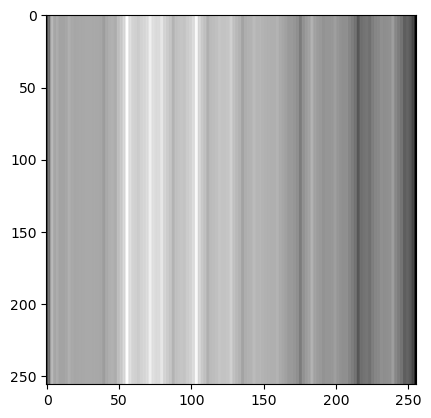

2
3
max size 256
5 (256, 256, 18) (256, 256, 10) (256, 256)
6 (256, 256, 18) (256, 256, 10) (256, 256)
7 (256, 256, 18) (256, 256, 10) (256, 256)
8 (256, 256, 18) (256, 256, 10) (256, 256)


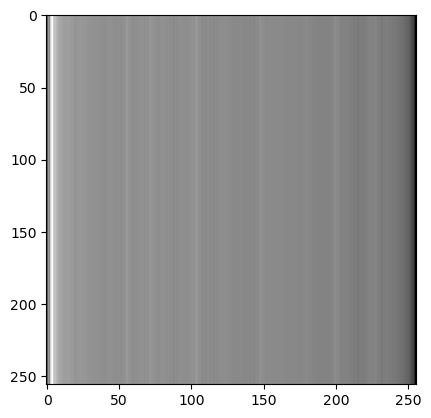

2
3
max size 256
5 (256, 256, 18) (256, 256, 10) (256, 256)
6 (256, 256, 18) (256, 256, 10) (256, 256)
7 (256, 256, 18) (256, 256, 10) (256, 256)
8 (256, 256, 18) (256, 256, 10) (256, 256)


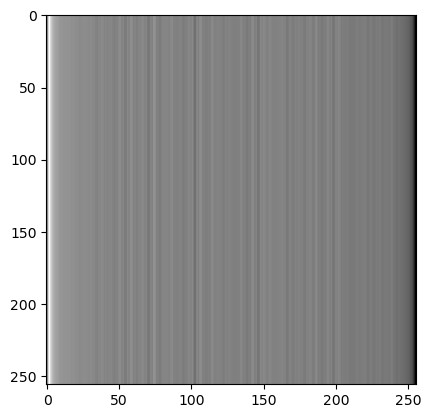

2
3
max size 256
5 (256, 256, 18) (256, 256, 10) (256, 256)
6 (256, 256, 18) (256, 256, 10) (256, 256)
7 (256, 256, 18) (256, 256, 10) (256, 256)
8 (256, 256, 18) (256, 256, 10) (256, 256)


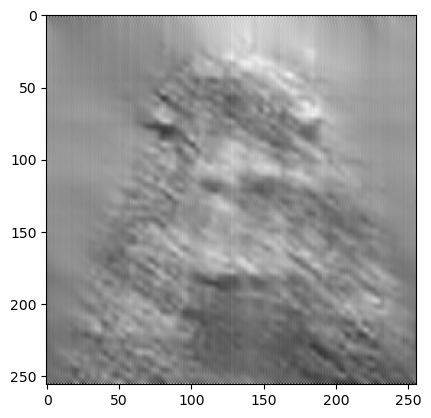

In [655]:
def supports_complex_torchupsample(img, scale, mode='bilinear'):

    blur_mag = torchvision.transforms.GaussianBlur(3, sigma=0.11)
    blur_phase = torchvision.transforms.GaussianBlur(5, sigma=0.11)

    if img.dtype in [torch.complex64, torch.complex32, torch.complex128]:
        real = torch.nn.functional.interpolate(img.real, scale, mode='nearest')
        imag = torch.nn.functional.interpolate(img.imag, scale, mode='nearest')
        return torch.complex(real, imag)
    else:
        return torch.nn.functional.interpolate(img, scale, mode=mode)

pyr = ShearletPyramid(256, 256, upsample_mode='torch')
print(img.shape)
coefs = pyr.expensive_compress(image)
for i in range(pyr.max_octaves - pyr.min_scale):
    coefs[pyr.max_octaves - i] *= 0
    recon = pyr.compute_reconstruction(image, coefs)
    plt.imshow(recon, cmap='gray')
    plt.show()

max octaves 8 256
torchutils.onceInit device = cuda:0
initSeeds(1)
(554, 554)
2
3
3
3
3
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)


/tmp/ipykernel_2060515/2036477480.py:24: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


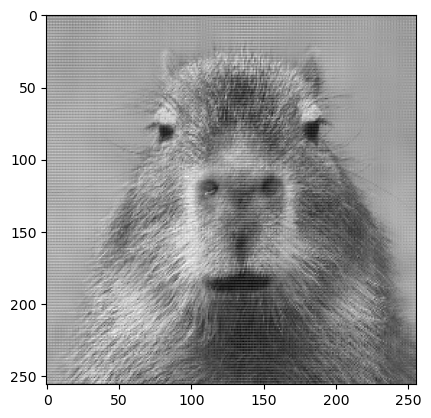

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


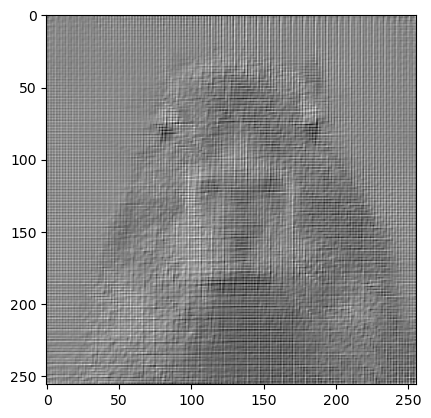

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


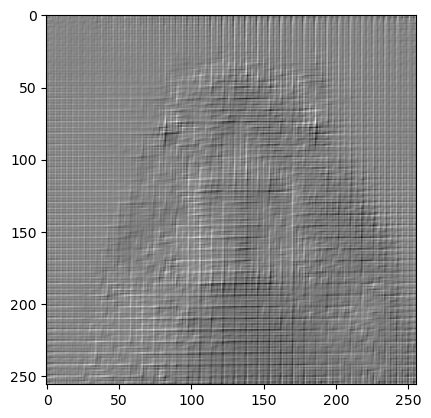

In [656]:
pyr = ShearletPyramid(256, 256)
print(img.shape)
coefs = pyr.compress(img)
coefs[pyr.max_octaves] *= 0
recon = pyr.compute_reconstruction(img, coefs)
plt.imshow(recon, cmap='gray')
plt.show()
coefs[pyr.max_octaves - 1] *= 0
recon = pyr.compute_reconstruction(img, coefs)
plt.imshow(recon, cmap='gray')
plt.show()

max octaves 8 256
torchutils.onceInit device = cuda:0
initSeeds(1)
(554, 554)
2
3
3
3
3


/tmp/ipykernel_2060515/2036477480.py:24: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


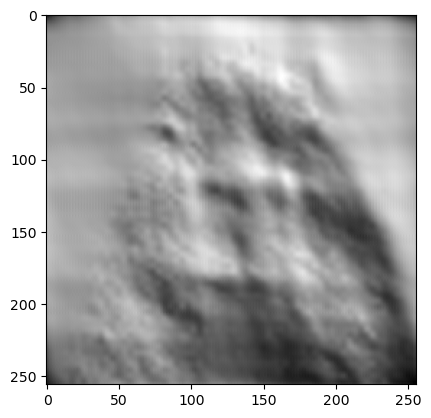

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


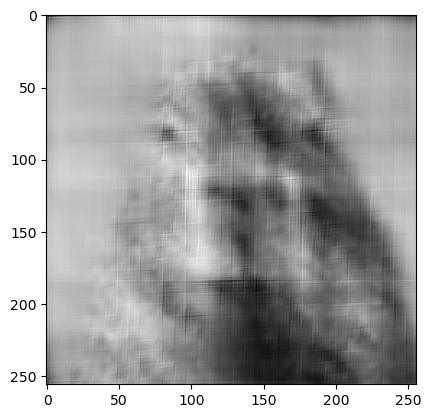

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


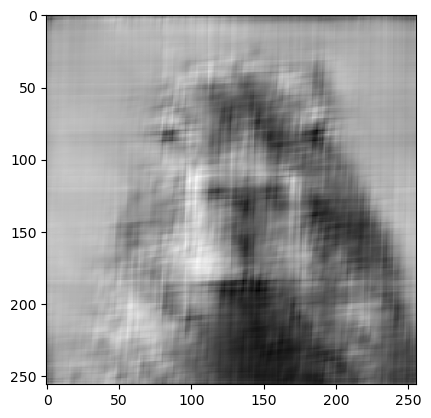

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


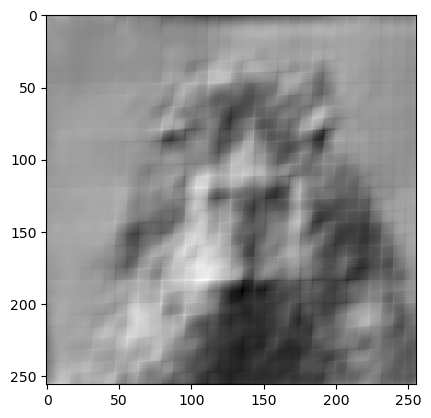

In [657]:

def supports_complex_torchupsample(img, scale, mode):

    blur_mag = torchvision.transforms.GaussianBlur(3, sigma=0.11)
    blur_phase = torchvision.transforms.GaussianBlur(5, sigma=0.11)

    if img.dtype in [torch.complex64, torch.complex32, torch.complex128]:
        real = blur_mag(torch.nn.functional.interpolate(img.real, scale, mode='nearest'))
        imag = blur_phase(torch.nn.functional.interpolate(img.imag, scale, mode='nearest'))
        return torch.complex(real, imag)
    else:
        return torch.nn.functional.interpolate(img, scale, mode=mode)

pyr = ShearletPyramid(256, 256, upsample_mode='torch')
print(img.shape)
coefs = pyr.compress(image)
for i in range(pyr.max_octaves - pyr.min_scale):
    coefs[pyr.max_octaves - i] *= 0
    recon = pyr.compute_reconstruction(image, coefs)
    plt.imshow(recon, cmap='gray')
    plt.show()

max octaves 8 256
torchutils.onceInit device = cuda:0
initSeeds(1)
(554, 554)
2
3
3
3
3


/tmp/ipykernel_2060515/2036477480.py:24: RuntimeWarning: divide by zero encountered in divide
  InversedualFrameWeights = 1 / dualFrameWeights


3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


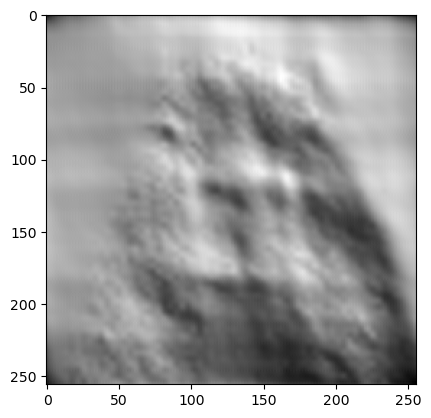

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


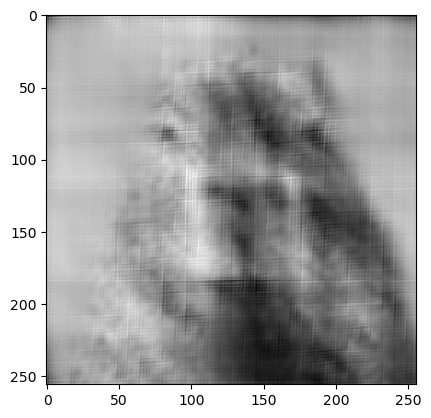

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


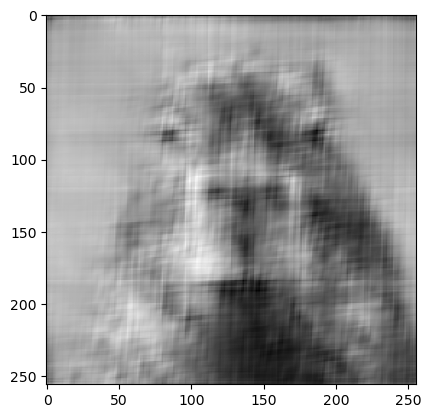

2
3
max size 256
5 (256, 256, 10) (256, 256, 10) (256, 256)
6 (256, 256, 10) (256, 256, 10) (256, 256)
7 (256, 256, 10) (256, 256, 10) (256, 256)
8 (256, 256, 10) (256, 256, 10) (256, 256)


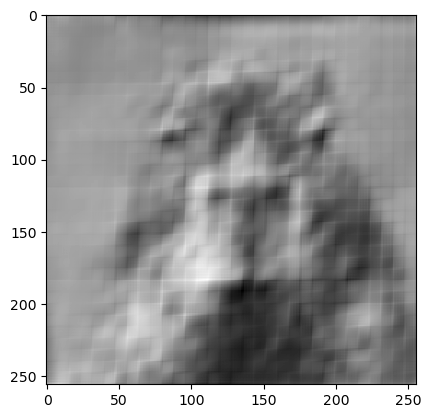

In [658]:
def supports_complex_torchupsample(img, scale, mode):

    blur_mag = torchvision.transforms.GaussianBlur(3, sigma=0.11)
    blur_phase = torchvision.transforms.GaussianBlur(5, sigma=0.11)

    if img.dtype in [torch.complex64, torch.complex32, torch.complex128]:
        real = torch.nn.functional.interpolate(img.real, scale, mode='nearest')
        imag = torch.nn.functional.interpolate(img.imag, scale, mode='nearest')
        return torch.complex(real, imag)
    else:
        return torch.nn.functional.interpolate(img, scale, mode=mode)

pyr = ShearletPyramid(256, 256, upsample_mode='torch')
print(img.shape)
coefs = pyr.compress(image)
for i in range(pyr.max_octaves - pyr.min_scale):
    coefs[pyr.max_octaves - i] *= 0
    recon = pyr.compute_reconstruction(image, coefs)
    plt.imshow(recon, cmap='gray')
    plt.show()

2
3


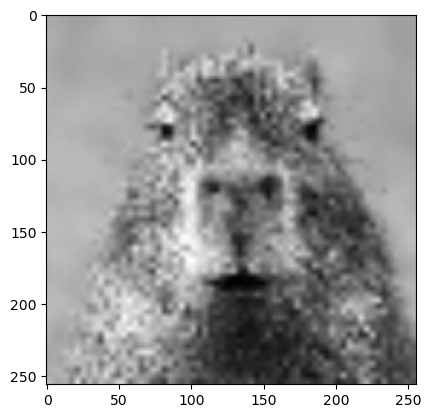

In [659]:
image = torchimg2np(torch.nn.functional.interpolate(torch.nn.functional.interpolate(npimg2torch(img), (64, 64), mode='bilinear'), (256, 256), mode='bilinear'))
plt.imshow(image, cmap='gray')
plt.show()

In [660]:
# with each level we eliminate, we get 66% effective sparsity.
series = [1]
for i in range(1, 12):
    print(2**(2*i), sum(series), 2**(2*i) / sum(series))
    series.append(2**(2*i))

4 1 4.0
16 5 3.2
64 21 3.0476190476190474
256 85 3.011764705882353
1024 341 3.002932551319648
4096 1365 3.0007326007326007
16384 5461 3.000183116645303
65536 21845 3.00004577706569
262144 87381 3.0000114441354526
1048576 349525 3.0000028610256777
4194304 1398101 3.000000715255908


In [661]:
for i in range(5):
    print(1 - (1 / (3**i)))

0.0
0.6666666666666667
0.8888888888888888
0.962962962962963
0.9876543209876543
